<a href="https://colab.research.google.com/github/Sage1ll1001/TD_ML/blob/main/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification: Fast vs Delayed
**Models:** Naive Bayes | KNN | Decision Tree

In [1]:
# Install dependencies
!pip install scikit-learn pandas numpy matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                              precision_score, recall_score, f1_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')
print(' Libraries loaded!')

 Libraries loaded!


##  Phase 1: Data Preprocessing

In [3]:
# Upload your CSV file when prompted
from google.colab import files
uploaded = files.upload()  # Upload Food_Delivery_Time_Prediction.csv
import io
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f'Shape: {df.shape}')
df.head()

Saving Food_Delivery_Time_Prediction.csv to Food_Delivery_Time_Prediction.csv
Shape: (200, 15)


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [4]:
print('Missing Values:')
print(df.isnull().sum())
print('\nData Types:')
print(df.dtypes)

Missing Values:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Data Types:
Order_ID                       object
Customer_Location              object
Restaurant_Location            object
Distance                      float64
Weather_Conditions             object
Traffic_Conditions             object
Delivery_Person_Experience      int64
Order_Priority                 object
Order_Time                     object
Vehicle_Type                   object
Restaurant_Rating             float64
Customer_Rating               float64
Delivery_Time         

In [5]:
# ── Haversine Distance ──
def haversine(loc1_str, loc2_str):
    def parse(s):
        s = s.strip('()')
        parts = s.split(',')
        return float(parts[0]), float(parts[1])
    lat1, lon1 = parse(loc1_str)
    lat2, lon2 = parse(loc2_str)
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['Haversine_Distance'] = df.apply(
    lambda r: haversine(r['Customer_Location'], r['Restaurant_Location']), axis=1)

# ── Target Variable: median split ──
median_time = df['Delivery_Time'].median()
df['Delivery_Status'] = (df['Delivery_Time'] > median_time).astype(int)
print(f'Median Delivery Time: {median_time:.2f} min')
print(f'Class Distribution:\n{df["Delivery_Status"].value_counts()}')

# ── Handle Missing Values ──
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# ── Label Encoding ──
le = LabelEncoder()
for col in cat_cols:
    df[col + '_enc'] = le.fit_transform(df[col])

print('\n Preprocessing done!')

Median Delivery Time: 72.78 min
Class Distribution:
Delivery_Status
0    100
1    100
Name: count, dtype: int64

 Preprocessing done!


In [6]:
# ── Feature Selection & Normalization ──
feature_cols = ['Haversine_Distance', 'Distance', 'Weather_Conditions_enc', 'Traffic_Conditions_enc',
                'Delivery_Person_Experience', 'Order_Priority_enc', 'Order_Time_enc',
                'Vehicle_Type_enc', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']

X = df[feature_cols]
y = df['Delivery_Status']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train: {X_train.shape[0]} | Test: {X_test.shape[0]}')

Train: 160 | Test: 40


##  Phase 2: Classification Models

In [7]:
results = {}

def evaluate(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        'accuracy':  accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred),
        'recall':    recall_score(y_te, y_pred),
        'f1':        f1_score(y_te, y_pred),
        'cm':        confusion_matrix(y_te, y_pred),
        'y_pred':    y_pred,
        'y_prob':    y_prob,
        'model':     model
    }
    print(f'\n{'='*45}')
    print(f'  {name}')
    print(f'{'='*45}')
    print(f'  Accuracy : {results[name]["accuracy"]:.4f}')
    print(f'  Precision: {results[name]["precision"]:.4f}')
    print(f'  Recall   : {results[name]["recall"]:.4f}')
    print(f'  F1-Score : {results[name]["f1"]:.4f}')
    print(classification_report(y_te, y_pred, target_names=['Fast','Delayed']))

print(' Evaluate function ready!')

 Evaluate function ready!


In [8]:
# ── 1. Naive Bayes ──
evaluate('Naive Bayes', GaussianNB(), X_train, y_train, X_test, y_test)


  Naive Bayes
  Accuracy : 0.4750
  Precision: 0.4706
  Recall   : 0.4000
  F1-Score : 0.4324
              precision    recall  f1-score   support

        Fast       0.48      0.55      0.51        20
     Delayed       0.47      0.40      0.43        20

    accuracy                           0.47        40
   macro avg       0.47      0.48      0.47        40
weighted avg       0.47      0.47      0.47        40



Best K = 19  (CV Accuracy = 0.5563)


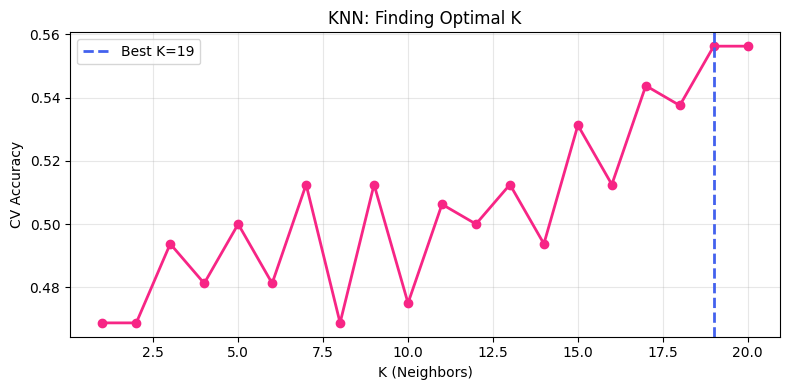


  KNN
  Accuracy : 0.4750
  Precision: 0.4815
  Recall   : 0.6500
  F1-Score : 0.5532
              precision    recall  f1-score   support

        Fast       0.46      0.30      0.36        20
     Delayed       0.48      0.65      0.55        20

    accuracy                           0.47        40
   macro avg       0.47      0.47      0.46        40
weighted avg       0.47      0.47      0.46        40



In [9]:
# ── 2. KNN with K-tuning ──
k_range = range(1, 21)
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k),
             X_train, y_train, cv=5).mean() for k in k_range]
best_k = list(k_range)[np.argmax(cv_scores)]
print(f'Best K = {best_k}  (CV Accuracy = {max(cv_scores):.4f})')

plt.figure(figsize=(8, 4))
plt.plot(list(k_range), cv_scores, 'o-', color='#F72585', lw=2)
plt.axvline(best_k, color='#4361EE', lw=2, linestyle='--', label=f'Best K={best_k}')
plt.xlabel('K (Neighbors)'); plt.ylabel('CV Accuracy')
plt.title('KNN: Finding Optimal K')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

evaluate('KNN', KNeighborsClassifier(n_neighbors=best_k), X_train, y_train, X_test, y_test)

In [10]:
# ── 3. Decision Tree with GridSearch ──
param_grid = {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}  (CV Accuracy = {gs.best_score_:.4f})')
best_dt = gs.best_estimator_
evaluate('Decision Tree', best_dt, X_train, y_train, X_test, y_test)

Best Params: {'max_depth': 3, 'min_samples_split': 2}  (CV Accuracy = 0.5437)

  Decision Tree
  Accuracy : 0.4500
  Precision: 0.4643
  Recall   : 0.6500
  F1-Score : 0.5417
              precision    recall  f1-score   support

        Fast       0.42      0.25      0.31        20
     Delayed       0.46      0.65      0.54        20

    accuracy                           0.45        40
   macro avg       0.44      0.45      0.43        40
weighted avg       0.44      0.45      0.43        40



##  Phase 3: Visualizations

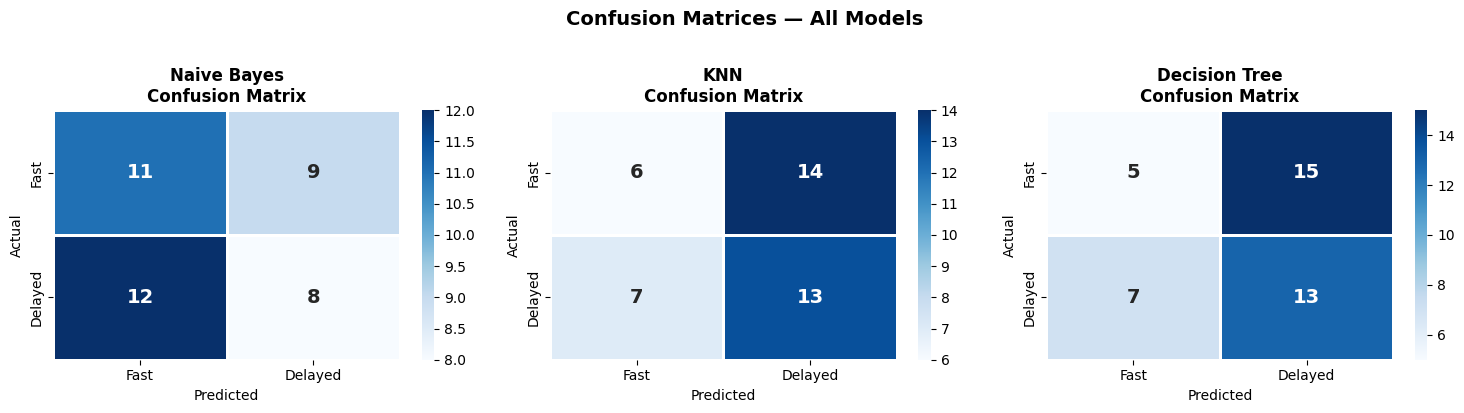

In [11]:
# ── Confusion Matrices ──
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
MODEL_COLORS = {'Naive Bayes': '#4361EE', 'KNN': '#F72585', 'Decision Tree': '#7209B7'}
models = list(results.keys())

for ax, name in zip(axes, models):
    cm = results[name]['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Fast','Delayed'], yticklabels=['Fast','Delayed'],
                linewidths=2, annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices — All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

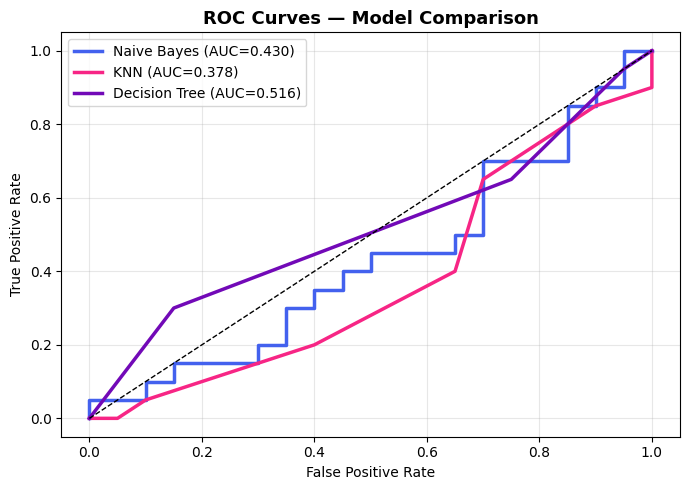

In [12]:
# ── ROC Curves ──
plt.figure(figsize=(7, 5))
for name, color in MODEL_COLORS.items():
    if results[name]['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_prob'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2.5, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Model Comparison', fontsize=13, fontweight='bold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

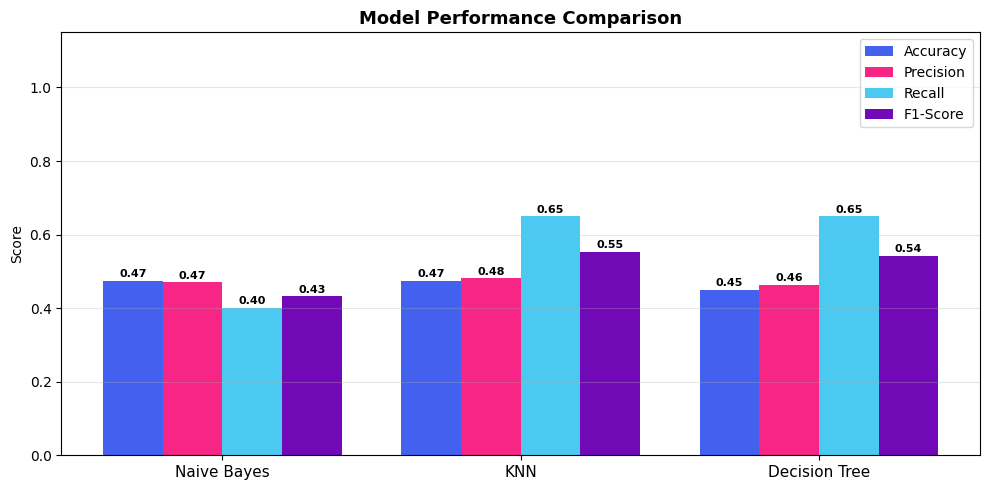

In [13]:
# ── Metrics Bar Chart ──
metrics_dict = {'Accuracy':  [results[m]['accuracy']  for m in models],
                'Precision': [results[m]['precision'] for m in models],
                'Recall':    [results[m]['recall']    for m in models],
                'F1-Score':  [results[m]['f1']        for m in models]}

x = np.arange(len(models))
width = 0.2
colors = ['#4361EE','#F72585','#4CC9F0','#7209B7']

fig, ax = plt.subplots(figsize=(10, 5))
for i, (metric, vals) in enumerate(metrics_dict.items()):
    bars = ax.bar(x + i*width, vals, width, label=metric, color=colors[i])
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.2f}', ha='center', fontsize=8, fontweight='bold')

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylim(0, 1.15)
ax.set_ylabel('Score'); ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.legend(); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

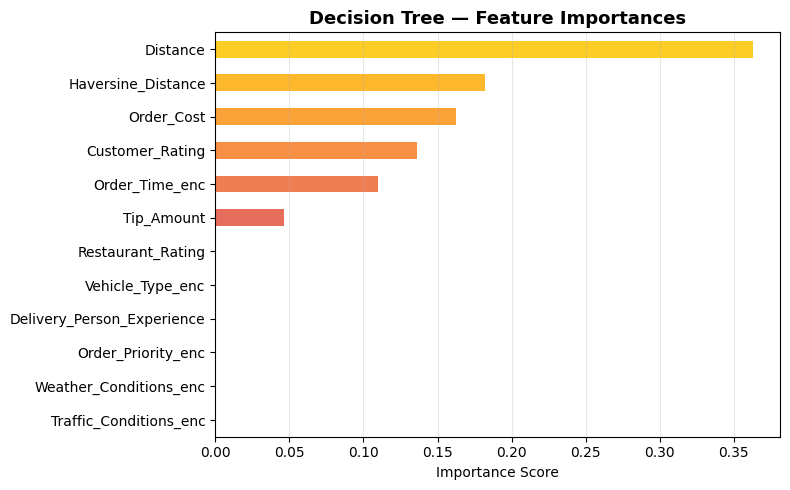

In [14]:
# ── Feature Importance (Decision Tree) ──
importances = best_dt.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
colors_fi = plt.cm.plasma(np.linspace(0.3, 0.9, len(feat_imp)))
feat_imp.plot(kind='barh', color=colors_fi)
plt.title('Decision Tree — Feature Importances', fontsize=13, fontweight='bold')
plt.xlabel('Importance Score')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout(); plt.show()

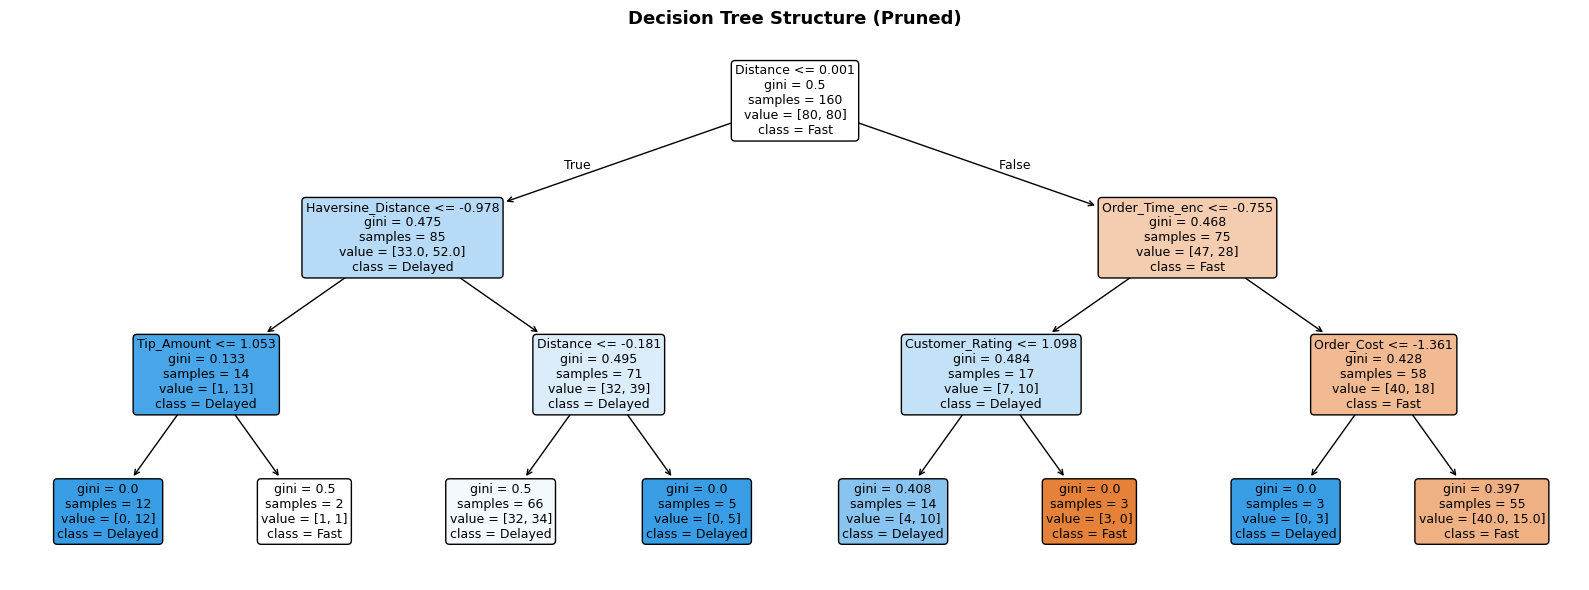

In [15]:
# ── Decision Tree Structure ──
plt.figure(figsize=(16, 6))
plot_tree(best_dt, feature_names=feature_cols,
          class_names=['Fast','Delayed'],
          filled=True, rounded=True, fontsize=9)
plt.title('Decision Tree Structure (Pruned)', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

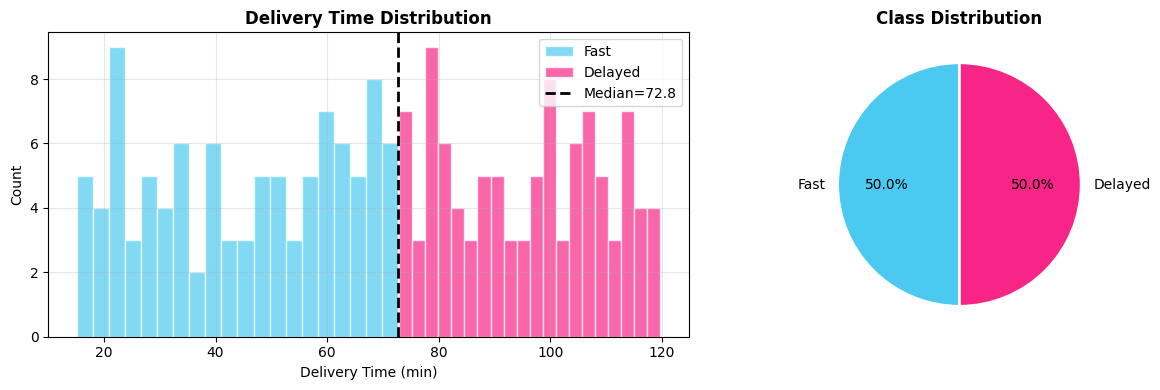

In [16]:
# ── Delivery Time Distribution ──
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Histogram
axes[0].hist(df[df['Delivery_Status']==0]['Delivery_Time'], bins=20,
             alpha=0.7, color='#4CC9F0', label='Fast', edgecolor='white')
axes[0].hist(df[df['Delivery_Status']==1]['Delivery_Time'], bins=20,
             alpha=0.7, color='#F72585', label='Delayed', edgecolor='white')
axes[0].axvline(median_time, color='black', lw=2, linestyle='--', label=f'Median={median_time:.1f}')
axes[0].set_title('Delivery Time Distribution', fontweight='bold')
axes[0].set_xlabel('Delivery Time (min)'); axes[0].set_ylabel('Count')
axes[0].legend(); axes[0].grid(alpha=0.3)

# Class pie chart
counts = df['Delivery_Status'].value_counts()
axes[1].pie(counts, labels=['Fast','Delayed'], autopct='%1.1f%%',
            colors=['#4CC9F0','#F72585'], startangle=90,
            wedgeprops={'edgecolor':'white', 'linewidth':2})
axes[1].set_title('Class Distribution', fontweight='bold')

plt.tight_layout(); plt.show()

In [17]:
# ── Final Summary ──
summary = pd.DataFrame({
    'Model': models,
    'Accuracy':  [f"{results[m]['accuracy']:.4f}"  for m in models],
    'Precision': [f"{results[m]['precision']:.4f}" for m in models],
    'Recall':    [f"{results[m]['recall']:.4f}"    for m in models],
    'F1-Score':  [f"{results[m]['f1']:.4f}"        for m in models],
}).set_index('Model')

print('\n FINAL MODEL COMPARISON')
print('='*50)
display(summary)

best_model = max(models, key=lambda m: results[m]['f1'])
print(f'\n Best Model by F1-Score: {best_model} ({results[best_model]["f1"]:.4f})')


 FINAL MODEL COMPARISON


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Naive Bayes,0.4750,0.4706,0.4000,0.4324
KNN,0.4750,0.4815,0.6500,0.5532
Decision Tree,0.4500,0.4643,0.6500,0.5417



 Best Model by F1-Score: KNN (0.5532)
